In [1]:
import pandas as pd
import numpy as np

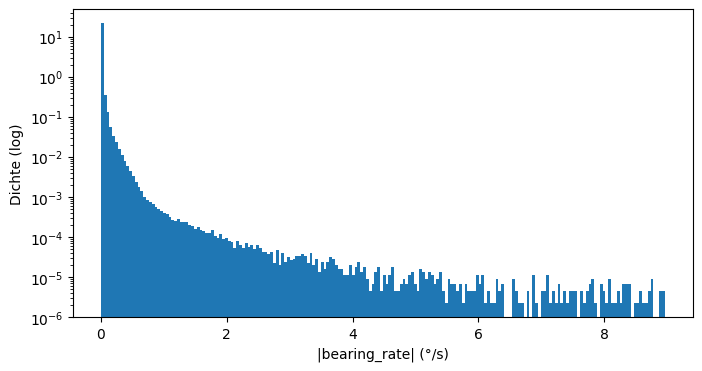

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV mit bearing_rate (in °/s) laden
df = pd.read_csv("/Users/ilyaskaracabey/Desktop/Enviroments/AIS/src/bearing/processed_data/05_distance.csv", usecols=["bearing_rate"])
rates = df["bearing_rate"].abs()

# Histogramm plotten (log-Skala hilft, die langen Schwänze zu sehen)
plt.figure(figsize=(8,4))
plt.hist(rates, bins=200, density=True, log=True)
plt.xlabel("|bearing_rate| (°/s)")
plt.ylabel("Dichte (log)")
plt.show()

In [45]:
import numpy as np

quantile_edges = np.quantile(rates, np.linspace(0,1,9))
print("Quantile:", quantile_edges)

Quantile: [0.00000000e+00 6.57253419e-17 4.91431863e-06 1.91385984e-05
 5.72956116e-05 1.88170613e-04 1.53618621e-03 6.84575378e-03
 8.95961677e+00]


In [46]:
pos = quantile_edges
neg = -pos[::-1]
rate_edges = np.unique(np.concatenate([neg, pos]))  # symmetrisch inkl. 0
print("Rate-Edges symmetrisch:", rate_edges)

Rate-Edges symmetrisch: [-8.95961677e+00 -6.84575378e-03 -1.53618621e-03 -1.88170613e-04
 -5.72956116e-05 -1.91385984e-05 -4.91431863e-06 -6.57253419e-17
 -0.00000000e+00  6.57253419e-17  4.91431863e-06  1.91385984e-05
  5.72956116e-05  1.88170613e-04  1.53618621e-03  6.84575378e-03
  8.95961677e+00]


In [47]:
iqr = np.percentile(rates,75) - np.percentile(rates,25)
n = len(rates)
bin_width = 2 * iqr / (n**(1/3))
n_bins = int(np.ceil((rates.max() - rates.min()) / bin_width))
edges = np.linspace(rates.min(), rates.max(), n_bins+1)
# Für symmetrische Bins dann noch spiegeln:
mid = np.searchsorted(edges, 0)
neg = -edges[:mid][::-1]
pos = edges[mid:]
rate_edges = np.unique(np.concatenate([neg, pos]))

## Schritt 0 – Daten laden & einen ersten Blick werfen

In [50]:
# 0.1  Pfad zu deiner Datei anpassen, falls nötig
csv_path = "/Users/ilyaskaracabey/Desktop/Enviroments/AIS/src/bearing/processed_data/05_distance.csv"

# 0.2  Einlesen
df = pd.read_csv(csv_path)

# 0.3  Grundinfos anzeigen
print("Zeilen:", len(df))
print("Spalten:", df.columns.tolist())
df.head(10)

/var/folders/xp/7528x0fs5fzcfyztpy9jt7x80000gn/T/ipykernel_16187/661467255.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Zeilen: 10042975
Spalten: ['# Timestamp', 'MMSI', 'Latitude', 'Longitude', 'Ship type', 'Destination', 'segment_idx', 'bearing', 'bearing_rate', 'dist_m']


,# Timestamp,MMSI,Latitude,Longitude,Ship type,Destination,segment_idx,bearing,bearing_rate,dist_m
0,2022-10-01 00:00:00,992111748,54.556202,11.285120,Undefined,NaN,0,185.769384,0.000000,2507.498516
1,2022-10-01 00:30:00,992111748,54.556217,11.285095,Undefined,NaN,1,185.810013,0.000000,2506.000370
2,2022-10-01 00:30:20,992111748,54.556216,11.285096,Undefined,NaN,1,185.808903,-0.000055,2506.051379
3,2022-10-01 00:30:40,992111748,54.556216,11.285096,Undefined,NaN,1,185.807793,-0.000055,2506.102388
4,2022-10-01 00:31:00,992111748,54.556215,11.285097,Undefined,NaN,1,185.806684,-0.000055,2506.153399
5,2022-10-01 00:31:20,992111748,54.556215,11.285098,Undefined,NaN,1,185.805574,-0.000055,2506.204410
6,2022-10-01 00:31:40,992111748,54.556215,11.285098,Undefined,NaN,1,185.804464,-0.000055,2506.255423
7,2022-10-01 00:32:00,992111748,54.556214,11.285099,Undefined,NaN,1,185.803355,-0.000055,2506.306436
8,2022-10-01 00:32:20,992111748,54.556213,11.285100,Undefined,NaN,1,185.802245,-0.000055,2506.357450
9,2022-10-01 00:32:40,992111748,54.556213,11.285100,Undefined,NaN,1,185.801136,-0.000055,2506.408465


In [52]:
import pandas as pd
from datetime import datetime

# CSV einlesen
df = pd.read_csv("/Users/ilyaskaracabey/Desktop/Enviroments/AIS/src/bearing/processed_data/05_distance.csv",
                 parse_dates=["# Timestamp"])

# Sortieren
df = df.sort_values(["MMSI", "# Timestamp"]).reset_index(drop=True)

# Zeit- und Bearing-Deltas berechnen
df["dt_s"] = df["# Timestamp"].diff().dt.total_seconds()
raw_db = df["bearing"].diff()

# Signed-Wrap :
df["delta_b"] = ((raw_db + 180) % 360) - 180

# Computed bearing_rate
df["bearing_rate_calc"] = df["delta_b"] / df["dt_s"]

# Vergleichen:
df[["# Timestamp","MMSI","bearing","bearing_rate","bearing_rate_calc"]].head(10)

/var/folders/xp/7528x0fs5fzcfyztpy9jt7x80000gn/T/ipykernel_16187/1451655731.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/ilyaskaracabey/Desktop/Enviroments/AIS/src/bearing/processed_data/05_distance.csv",


,# Timestamp,MMSI,bearing,bearing_rate,bearing_rate_calc
0,2022-10-05 07:41:33,111211501,271.124724,0.000000,NaN
1,2022-10-05 07:41:53,111211501,271.427535,0.015141,0.015141
2,2022-10-05 07:42:13,111211501,271.741931,0.015720,0.015720
3,2022-10-05 07:42:33,111211501,272.109498,0.018378,0.018378
4,2022-10-05 07:42:53,111211501,272.547997,0.021925,0.021925
5,2022-10-05 07:43:13,111211501,272.973530,0.021277,0.021277
6,2022-10-05 07:43:33,111211501,273.360753,0.019361,0.019361
7,2022-10-05 07:43:53,111211501,273.337277,-0.001174,-0.001174
8,2022-10-05 07:44:13,111211501,273.157192,-0.009004,-0.009004
9,2022-10-05 07:44:33,111211501,273.027777,-0.006471,-0.006471


In [53]:
df["bearing_rate"].min()

np.float64(-8.959616767895332)

In [54]:
df["Ship type"].unique()

array(['Undefined', 'Pleasure', 'Sailing', 'Cargo', 'Tanker', 'Dredging',
       'Other', 'Tug', 'Law enforcement', 'Passenger', 'SAR', 'Military',
       'Anti-pollution', 'Towing', 'Fishing', 'HSC', 'Port tender',
       'Pilot', 'Reserved', 'Not party to conflict', 'Spare 1',
       'Towing long/wide'], dtype=object)

In [27]:
k = 0
for s_type in df["Ship type"].unique():
    schiff_typ = df[df["Ship type"]==s_type]
    laenge = len(schiff_typ["MMSI"].unique())
    k = k + laenge
    print(k)

24
1026
1050
1423
1435
1467
1471
1486
1495
1517
1523
1524
1536
1538
1539
1544
1549
1550
1552
1553


In [28]:
import pandas as pd

# 1) Wie viele Ship types hat jede MMSI?
type_counts = df.groupby("MMSI")["Ship type"].nunique()

# 2) Zeige dir die MMSIs, die mehr als 1 Ship type haben
multi_type = type_counts[type_counts > 1].sort_values(ascending=False)
print(f"{len(multi_type)} MMSIs mit >1 Ship type:\n", multi_type.head())

# 3) Für ein konkretes Beispiel MMSI die unterschiedlichen Typen ausgeben
mmsi = multi_type.index[0]
print(f"\nMMSI {mmsi} kam mit diesen Ship types vor:\n",
      df.loc[df["MMSI"]==mmsi, "Ship type"].unique())

1 MMSIs mit >1 Ship type:
 MMSI
209852000    2
Name: Ship type, dtype: int64

MMSI 209852000 kam mit diesen Ship types vor:
 ['Other' 'Dredging']


In [99]:
mmsi = df[df["MMSI"]==219012076]
mmsi

,# Timestamp,MMSI,Latitude,Longitude,Destination,segment_idx,bearing,bearing_rate,dist_m
403,2022-10-01 00:01:41,219012076,54.729728,10.945588,NYBORG,0,307.334513,0.000000e+00,27826.139257
404,2022-10-01 00:02:01,219012076,54.730164,10.944707,NYBORG,0,307.343871,4.678532e-04,27900.733667
405,2022-10-01 00:02:21,219012076,54.730574,10.943861,NYBORG,0,307.351207,3.668397e-04,27971.688151
406,2022-10-01 00:02:41,219012076,54.730976,10.943054,NYBORG,0,307.360083,4.437618e-04,28040.111184
407,2022-10-01 00:03:01,219012076,54.731361,10.942309,NYBORG,0,307.370904,5.410762e-04,28104.272614
...,...,...,...,...,...,...,...,...,...
9255,2022-10-25 22:00:56,219012076,54.564677,11.666647,NYSTED OWF A2,6,93.480864,-5.986226e-05,24472.121514
9256,2022-10-25 22:01:16,219012076,54.564677,11.666647,NYSTED OWF A2,6,93.480696,-8.409563e-06,24472.127561
9257,2022-10-25 22:01:36,219012076,54.564678,11.666647,NYSTED OWF A2,6,93.480507,-9.443938e-06,24472.122219
9258,2022-10-25 22:01:56,219012076,54.564680,11.666647,NYSTED OWF A2,6,93.480039,-2.340456e-05,24472.108982


In [100]:
mmsi.Destination.unique()

array(['NYBORG', 'NYSTED OWF A2', 'NYSTED OWF', 'GEDSER'], dtype=object)

In [101]:
mmsi.segment_idx.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [58]:
mmsi[mmsi.segment_idx==2]

,# Timestamp,MMSI,Latitude,Longitude,Destination,segment_idx,bearing,bearing_rate,dist_m
5579,2022-10-08 10:39:39,219012076,54.734422,10.938888,NYSTED OWF,2,307.650232,0.000000,28485.880999
5580,2022-10-08 10:39:59,219012076,54.733956,10.939690,NYSTED OWF,2,307.630356,-0.000994,28413.314762
5581,2022-10-08 10:40:19,219012076,54.733490,10.940493,NYSTED OWF,2,307.610381,-0.000999,28340.751378
5582,2022-10-08 10:40:39,219012076,54.733047,10.941335,NYSTED OWF,2,307.597560,-0.000641,28267.718946
5583,2022-10-08 10:40:59,219012076,54.732602,10.942185,NYSTED OWF,2,307.584994,-0.000628,28194.159398
...,...,...,...,...,...,...,...,...,...
6533,2022-10-08 15:57:39,219012076,54.559893,11.650712,NYSTED OWF,2,94.943160,0.000182,23486.333994
6534,2022-10-08 15:57:59,219012076,54.559883,11.650751,NYSTED OWF,2,94.945380,0.000111,23488.933314
6535,2022-10-08 15:58:19,219012076,54.559878,11.650765,NYSTED OWF,2,94.946452,0.000054,23489.900860
6536,2022-10-08 15:58:39,219012076,54.559875,11.650778,NYSTED OWF,2,94.947071,0.000031,23490.792282


In [59]:
test = mmsi[mmsi.segment_idx==1]
test

,# Timestamp,MMSI,Latitude,Longitude,Destination,segment_idx,bearing,bearing_rate,dist_m
413,2022-10-03 22:31:40,219012076,54.732428,10.935792,NYSTED OWF A2,1,307.052460,0.000000,28511.239895
414,2022-10-03 22:32:00,219012076,54.732039,10.936606,NYSTED OWF A2,1,307.045863,-0.000330,28443.336449
415,2022-10-03 22:32:20,219012076,54.731668,10.937382,NYSTED OWF A2,1,307.039401,-0.000323,28378.548881
416,2022-10-03 22:32:40,219012076,54.731313,10.938124,NYSTED OWF A2,1,307.033120,-0.000314,28316.587825
417,2022-10-03 22:33:00,219012076,54.730925,10.938935,NYSTED OWF A2,1,307.026417,-0.000335,28248.875204
...,...,...,...,...,...,...,...,...,...
5574,2022-10-05 03:12:00,219012076,54.730380,10.938880,NYBORG,1,306.923383,0.000584,28215.493033
5575,2022-10-05 03:12:20,219012076,54.730785,10.938077,NYBORG,1,306.934132,0.000537,28283.907806
5576,2022-10-05 03:12:40,219012076,54.731216,10.937259,NYBORG,1,306.948388,0.000713,28354.873997
5577,2022-10-05 03:13:00,219012076,54.731600,10.936485,NYBORG,1,306.957468,0.000454,28420.347889


In [64]:
route_1 = test[test["Destination"]=="NYSTED OWF A2"]
route_1

,# Timestamp,MMSI,Latitude,Longitude,Destination,segment_idx,bearing,bearing_rate,dist_m
413,2022-10-03 22:31:40,219012076,54.732428,10.935792,NYSTED OWF A2,1,307.052460,0.000000e+00,28511.239895
414,2022-10-03 22:32:00,219012076,54.732039,10.936606,NYSTED OWF A2,1,307.045863,-3.298408e-04,28443.336449
415,2022-10-03 22:32:20,219012076,54.731668,10.937382,NYSTED OWF A2,1,307.039401,-3.231104e-04,28378.548881
416,2022-10-03 22:32:40,219012076,54.731313,10.938124,NYSTED OWF A2,1,307.033120,-3.140582e-04,28316.587825
417,2022-10-03 22:33:00,219012076,54.730925,10.938935,NYSTED OWF A2,1,307.026417,-3.351168e-04,28248.875204
...,...,...,...,...,...,...,...,...,...
4309,2022-10-04 20:10:20,219012076,54.565062,11.666738,NYSTED OWF A2,1,93.379802,-5.816883e-18,24475.210807
4310,2022-10-04 20:10:40,219012076,54.565062,11.666738,NYSTED OWF A2,1,93.379802,-5.816883e-18,24475.210807
4311,2022-10-04 20:11:00,219012076,54.565062,11.666738,NYSTED OWF A2,1,93.379799,-1.623176e-07,24475.232324
4312,2022-10-04 20:11:20,219012076,54.565062,11.666740,NYSTED OWF A2,1,93.379783,-8.115838e-07,24475.339908


In [65]:
route_2 = test[test["Destination"]=="NYBORG"]
route_2

,# Timestamp,MMSI,Latitude,Longitude,Destination,segment_idx,bearing,bearing_rate,dist_m
4314,2022-10-04 20:12:00,219012076,54.565062,11.666740,NYBORG,1,93.379783,-9.118312e-18,24475.339908
4315,2022-10-04 20:12:20,219012076,54.565062,11.666740,NYBORG,1,93.379783,-9.118312e-18,24475.339908
4316,2022-10-04 20:12:40,219012076,54.565062,11.666740,NYBORG,1,93.379783,-9.118312e-18,24475.339908
4317,2022-10-04 20:13:00,219012076,54.565062,11.666740,NYBORG,1,93.379783,-9.118312e-18,24475.339908
4318,2022-10-04 20:13:20,219012076,54.565062,11.666742,NYBORG,1,93.379763,-9.738915e-07,24475.469009
...,...,...,...,...,...,...,...,...,...
5574,2022-10-05 03:12:00,219012076,54.730380,10.938880,NYBORG,1,306.923383,5.840395e-04,28215.493033
5575,2022-10-05 03:12:20,219012076,54.730785,10.938077,NYBORG,1,306.934132,5.374484e-04,28283.907806
5576,2022-10-05 03:12:40,219012076,54.731216,10.937259,NYBORG,1,306.948388,7.127743e-04,28354.873997
5577,2022-10-05 03:13:00,219012076,54.731600,10.936485,NYBORG,1,306.957468,4.539831e-04,28420.347889


# cleaned ais

In [102]:
# 0.1  Pfad zu deiner Datei anpassen, falls nötig
csv_path = "/Users/ilyaskaracabey/Desktop/Enviroments/AIS/src/bearing/processed_data/01_cleaned.csv"

# 0.2  Einlesen
df_cleaned = pd.read_csv(csv_path)

# 0.3  Grundinfos anzeigen
print("Zeilen:", len(df_cleaned))
print("Spalten:", df_cleaned.columns.tolist())
df_cleaned.head()

Zeilen: 2039215
Spalten: ['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D', 'geometry', 'dist_to_port']


,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Draught,Destination,ETA,Data source type,A,B,C,D,geometry,dist_to_port
0,2022-10-01 00:00:20,Class A,229344000,54.530143,11.356242,Under way using engine,0.0,9.4,118.1,122.0,...,5.9,LTKLJ,02/10/2022 09:00:00,AIS,83.0,12.0,6.0,7.0,POINT (11.356242 54.530143),10867.278659
1,2022-10-01 00:00:26,Class A,229344000,54.529957,11.356872,Under way using engine,0.0,9.4,117.8,122.0,...,5.9,LTKLJ,02/10/2022 09:00:00,AIS,83.0,12.0,6.0,7.0,POINT (11.356871999999997 54.52995700000001),10943.744708
2,2022-10-01 00:00:32,Class A,249225000,54.597683,11.221700,Under way using engine,-1.1,14.7,297.5,297.0,...,8.9,USBAL,14/10/2022 02:00:00,AIS,160.0,20.0,6.0,22.0,POINT (11.2217 54.597683),8943.831227
3,2022-10-01 00:00:33,Class A,249225000,54.597840,11.221180,Under way using engine,0.0,14.6,297.4,297.0,...,8.9,USBAL,14/10/2022 02:00:00,AIS,160.0,20.0,6.0,22.0,POINT (11.221179999999999 54.59784),9007.280701
4,2022-10-01 00:00:36,Class A,229344000,54.529730,11.357615,Under way using engine,0.0,9.4,118.1,122.0,...,5.9,LTKLJ,02/10/2022 09:00:00,AIS,83.0,12.0,6.0,7.0,POINT (11.357614999999997 54.52973),11034.916774


In [103]:
mmsi_cleaned = df_cleaned[df_cleaned["MMSI"]==219012076]
mmsi_cleaned.head(5)

,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Draught,Destination,ETA,Data source type,A,B,C,D,geometry,dist_to_port
21,2022-10-01 00:01:41,Class A,219012076,54.729728,10.945588,Under way using engine,NaN,6.6,311.8,295.0,...,2.8,NYBORG,01/10/2022 12:00:00,AIS,27.0,27.0,10.0,2.0,POINT (10.945587999999999 54.729728),48823.981795
24,2022-10-01 00:01:49,Class A,219012076,54.729943,10.945148,Under way using engine,0.0,6.6,311.3,295.0,...,2.8,NYBORG,01/10/2022 12:00:00,AIS,27.0,27.0,10.0,2.0,POINT (10.945147999999998 54.729943000000006),48888.144912
28,2022-10-01 00:02:00,Class A,219012076,54.730145,10.944748,Under way using engine,0.0,6.6,310.9,296.0,...,2.8,NYBORG,01/10/2022 12:00:00,AIS,27.0,27.0,10.0,2.0,POINT (10.944748 54.730145),48947.284162
31,2022-10-01 00:02:09,Class A,219012076,54.730320,10.944375,Under way using engine,0.0,6.6,310.5,295.0,...,2.8,NYBORG,01/10/2022 12:00:00,AIS,27.0,27.0,10.0,2.0,POINT (10.944374999999999 54.73032),49000.779707
36,2022-10-01 00:02:19,Class A,219012076,54.730537,10.943933,Under way using engine,0.0,6.6,310.1,296.0,...,2.8,NYBORG,01/10/2022 12:00:00,AIS,27.0,27.0,10.0,2.0,POINT (10.943932999999998 54.73053699999999),49065.361285


In [104]:
mmsi_cleaned.Destination.unique()

array(['NYBORG', 'NYSTED OWF A2', 'NYSTED OWF', 'GEDSER'], dtype=object)

In [110]:
import pandas as pd

for dest in mmsi_cleaned.Destination.unique():
    df_cleaned_sort = mmsi_cleaned[mmsi_cleaned["Destination"] == dest].copy()

    # 1) Explizites Parsing
    df_cleaned_sort["# Timestamp"] = pd.to_datetime(
        df_cleaned_sort["# Timestamp"],
        format="%Y-%m-%d %H:%M:%S",   # exakt 2022-10-03 22:31:40
        errors="coerce"               # unparseable → NaT
    )

    # 2) Sortieren und diff
    df_cleaned_sort = df_cleaned_sort.sort_values("# Timestamp")
    df_cleaned_sort["dt"] = df_cleaned_sort["# Timestamp"].diff()

    # 3) Lücken > 20 Min
    mask = df_cleaned_sort["dt"] > pd.Timedelta(minutes=10)
    gaps = df_cleaned_sort.loc[mask, ["# Timestamp", "dt"]]

    print(f"Anzahl Lücken >20 Min: {len(gaps)}")
    print(gaps)

Anzahl Lücken >20 Min: 2
                # Timestamp               dt
284439  2022-10-04 20:11:59  3 days 20:06:59
1515343 2022-10-23 18:17:06 18 days 15:03:46
Anzahl Lücken >20 Min: 2
                # Timestamp               dt
1211477 2022-10-18 17:19:49 13 days 21:07:51
1629018 2022-10-25 15:52:36  6 days 17:39:54
Anzahl Lücken >20 Min: 1
               # Timestamp              dt
729434 2022-10-11 09:09:00 2 days 17:09:51
Anzahl Lücken >20 Min: 0
Empty DataFrame
Columns: [# Timestamp, dt]
Index: []


## Schritt 1 – Raster‐Parameter setzen und die Daten bin-vorbereiten


In [4]:
# Schritt 1 ────────────────────────────────────────────────
import numpy as np
import pandas as pd

# 1.1  Raster-Parameter (gern später anpassen)
AZ_BIN_DEG = 5                       # Bearing-Bin-Breite: 5°
RATE_EDGES = [0, .01, .03, .1, .3, 1, 3, 10]   # |Bearing-Rate|-Bins in °/s

R_MAX_M  = 20_000                    # Max-Radius für später
R_STEP_M = 500                       # Distanz-Bin-Breite

# 1.2  Bearing in Azimut-Bins einteilen
df["bearing_bin"] = (df["bearing"] // AZ_BIN_DEG) * AZ_BIN_DEG

# 1.3  Absoluten Bearing-Rate-Wert und Rate-Bin bestimmen
df["bearing_rate_abs"] = df["bearing_rate"].abs()
df["bearing_rate_bin"] = pd.cut(df["bearing_rate_abs"],
                        bins=RATE_EDGES,
                        right=False,
                        labels=RATE_EDGES[:-1]).astype(float)

# 1.4  Kurzer Check
print("Eindeutige theta_bin-Werte:", sorted(df["bearing_bin"].unique())[:10], "...")
print("Eindeutige rate_bin-Werte :", sorted(df["bearing_rate_bin"].dropna().unique())[:10], "...")
df.head()

Eindeutige theta_bin-Werte: [np.float64(0.0), np.float64(5.0), np.float64(10.0), np.float64(15.0), np.float64(20.0), np.float64(25.0), np.float64(30.0), np.float64(35.0), np.float64(40.0), np.float64(45.0)] ...
Eindeutige rate_bin-Werte : [np.float64(0.0), np.float64(0.01), np.float64(0.03), np.float64(0.1), np.float64(0.3), np.float64(1.0), np.float64(3.0)] ...


,# Timestamp,MMSI,Latitude,Longitude,Destination,bearing,bearing_rate,dist_m,bearing_bin,bearing_rate_abs,bearing_rate_bin
0,2022-10-01 00:00:20,229344000,54.530143,11.356242,LTKLJ,141.098699,0.000000,6930.459417,140.0,0.000000,0.00
1,2022-10-01 00:00:40,229344000,54.529653,11.357865,LTKLJ,140.711241,-0.019373,7039.053050,140.0,0.019373,0.01
2,2022-10-01 00:01:00,229344000,54.529249,11.359166,LTKLJ,140.414996,-0.014812,7127.190917,140.0,0.014812,0.01
3,2022-10-01 00:01:20,229344000,54.528824,11.360489,LTKLJ,140.129870,-0.014256,7218.308615,140.0,0.014256,0.01
4,2022-10-01 00:01:40,229344000,54.528394,11.361816,LTKLJ,139.852954,-0.013846,7310.139577,135.0,0.013846,0.01


## Schritt 2 – Distanz in 500-Meter-Bins packen


In [5]:
# Schritt 2 ────────────────────────────────────────────────
import numpy as np

# 2.1  Distanz-Bin-Zentren (rangeVec) anlegen
range_vec = np.arange(0, R_MAX_M, R_STEP_M) + R_STEP_M / 2   # z. B. 250, 750, …

# 2.2  jedem Datenpunkt einen Distanz-Bin-Index zuweisen
df["dist_bin"] = (df["dist_m"] // R_STEP_M).clip(upper=len(range_vec)-1).astype(int)

# 2.3  Check
print("range_vec Länge:", len(range_vec), "erste Werte:", range_vec[:5])
print("dist_bin unique:", sorted(df["dist_bin"].unique())[:10], "...")
df.head()

range_vec Länge: 40 erste Werte: [ 250.  750. 1250. 1750. 2250.]
dist_bin unique: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ...


,# Timestamp,MMSI,Latitude,Longitude,Destination,bearing,bearing_rate,dist_m,bearing_bin,bearing_rate_abs,bearing_rate_bin,dist_bin
0,2022-10-01 00:00:20,229344000,54.530143,11.356242,LTKLJ,141.098699,0.000000,6930.459417,140.0,0.000000,0.00,13
1,2022-10-01 00:00:40,229344000,54.529653,11.357865,LTKLJ,140.711241,-0.019373,7039.053050,140.0,0.019373,0.01,14
2,2022-10-01 00:01:00,229344000,54.529249,11.359166,LTKLJ,140.414996,-0.014812,7127.190917,140.0,0.014812,0.01,14
3,2022-10-01 00:01:20,229344000,54.528824,11.360489,LTKLJ,140.129870,-0.014256,7218.308615,140.0,0.014256,0.01,14
4,2022-10-01 00:01:40,229344000,54.528394,11.361816,LTKLJ,139.852954,-0.013846,7310.139577,135.0,0.013846,0.01,14


## Schritt 3

In [6]:
# Schritt 3 ────────────────────────────────────────────────
# 3-D-Histogramm (bearing_bin × bearing_rate_bin × dist_bin)

import numpy as np
import pandas as pd   # für pd.isna in der Schleife

# 3.1  Anzahl Bins je Achse
AZ_BINS   = 360 // AZ_BIN_DEG            # z. B. 72
RATE_BINS = len(RATE_EDGES) - 1          # z. B. 7
R_BINS    = len(range_vec)               # z. B. 40

# 3.2  Leeres 3-D-Array
hist = np.zeros((AZ_BINS, RATE_BINS, R_BINS), dtype=int)

# 3.3  Gruppen zählen
grp_counts = (
    df.groupby(["bearing_bin", "bearing_rate_bin", "dist_bin"])
      .size()
)

# Mapping von Rate-Bin-Wert (linker Rand) zum Index 0…RATE_BINS-1
rate_val_to_idx = {v: i for i, v in enumerate(RATE_EDGES[:-1])}

# 3.4  Counts einsortieren
for (be_bin, ra_bin, dist_bin), cnt in grp_counts.items():
    if pd.isna(ra_bin):
        continue                # Zeilen ohne gültigen Rate-Bin überspringen
    be_i = int(be_bin / AZ_BIN_DEG)
    ra_i = rate_val_to_idx[ra_bin]
    hist[be_i, ra_i, int(dist_bin)] = cnt

# 3.5  Kurzer Check
print("hist shape (az, rate, dist):", hist.shape)
print("Summe aller Counts        :", hist.sum())

hist shape (az, rate, dist): (72, 7, 40)
Summe aller Counts        : 977539


## Schritt 4

In [7]:
# Schritt 4 ────────────────────────────────────────────────
import numpy as np

# 4.1  Zeilensummen über die Distanz-Achse
row_sums = hist.sum(axis=2, keepdims=True)

# 4.2  Division – nur dort, wo Summe > 0
prob_cube = np.divide(hist, row_sums, where=row_sums != 0)

# 4.3  Kontrolle
non_empty = np.count_nonzero(row_sums.squeeze() > 0)
print("Nicht-leere (bearing_bin (θ), bearing_rate_bin (ω))-Paare:", non_empty, "von", row_sums.size)
print("Beispiel-Summe erster aktiver Bin:",
      prob_cube[row_sums.squeeze() > 0][0].sum())


Nicht-leere (bearing_bin (θ), bearing_rate_bin (ω))-Paare: 403 von 504
Beispiel-Summe erster aktiver Bin: 1.0


## Schritt 5 – Lookup-Tabelle speichern & Runtime-Funktion bereitstellen


In [8]:
import pickle, os, json

# 5.1  Sammle alles in ein Dict
lut = {
    "params": {
        "az_bin_deg": AZ_BIN_DEG,
        "rate_edges": RATE_EDGES,         # list
        "range_vec":  range_vec.tolist(), # list
    },
    "prob_cube": prob_cube.astype("float32")  # 4× kleiner
}

# 5.2  Pfad
out_pkl = "data/processed/bearing/range_lut.pkl"
os.makedirs(os.path.dirname(out_pkl), exist_ok=True)

with open(out_pkl, "wb") as f:
    pickle.dump(lut, f)

print("✅ Lookup-Table gespeichert:", out_pkl)

✅ Lookup-Table gespeichert: data/processed/bearing/range_lut.pkl


## Schritt 6

In [9]:
import numpy as np, pickle

def load_range_lut(path="data/processed/bearing/range_lut.pkl"):
    with open(path, "rb") as f:
        return pickle.load(f)

def lookup_range_pdf(theta, omega, lut):
    p       = lut["params"]
    cube    = lut["prob_cube"]

    # 1) Bearing-Bin
    th_i = int((theta % 360) // p["az_bin_deg"])

    # 2) Rate-Bin (Absolutwert)
    abs_ω = abs(omega)
    edges = p["rate_edges"]
    ra_i  = np.searchsorted(edges, abs_ω, side="right") - 1
    if ra_i < 0 or ra_i >= len(edges)-1:
        return None, None          # außerhalb Raster

    pdf = cube[th_i, ra_i, :]
    if pdf.sum() == 0:
        return None, None          # kein Historien-Datensatz

    return np.array(p["range_vec"]), pdf

In [10]:
lut = load_range_lut()
range_vec, prob = lookup_range_pdf(theta=139.852954, omega=0.013846, lut=lut)

if prob is not None:
    print("Erwartete Distanz (m):", np.dot(range_vec, prob).round(1))
    print("Top-3 Wahrscheinlichkeiten:")
    for r, p in sorted(zip(range_vec, prob), key=lambda t: -t[1])[:5]:
        print(f"  R ≈ {r:6.0f} m   P={p:.3f}")
else:
    print("Keine Historie für diese (θ,ω)-Kombination.")

Erwartete Distanz (m): 8330.2
Top-3 Wahrscheinlichkeiten:
  R ≈   8750 m   P=0.132
  R ≈   8250 m   P=0.128
  R ≈   9250 m   P=0.117
  R ≈   7750 m   P=0.109
  R ≈   9750 m   P=0.097


## Plot